# Instalação das bibliotécas

In [121]:
#Importar principais bibliotecas para auxiliar na leitura, manipulação, tratamento e análise dos dados
import pandas as pd
import numpy as np

#Função para retorna o ano atual
from datetime import datetime

#Importar a biblioteca para criação de gráficos
from matplotlib import pyplot as plt
import seaborn as sns

#Instalação do modelo para análise e previsão de séries temporais
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Ferramenta para normalização de características (features) em um intervalo especificado
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Carregar arquivo

In [122]:
dados = pd.read_csv('https://data.cityofchicago.org/api/views/gj7a-742p/rows.csv?accessType=DOWNLOAD')
#Origem dos dados: https://data.world/cityofchicago/gj7a-742p
#Usa biblioteca pandas para abrir arquivo .csv, que contem os dados a serem analisados, direto do site.

# Análise dos dados

In [123]:
#Verificar se o arquivo a ser analisado esta correto. Podendo ser visualizado os dados iniciais
dados.head()

,TIME_PERIOD,TIME_PERIOD_START,TIME_PERIOD_END,PRIMARY_TYPE,AGE,SEX,RACE,JUVENILE_I,DOMESTIC_I,GUNSHOT_INJURY_I,NUMBER_OF_VICTIMS
0,2011 Q1,01/01/2011,03/31/2011,HOMICIDE,30-39,M,BLK,False,False,NO,1
1,2000 Q4,10/01/2000,12/31/2000,HOMICIDE,70-79,M,WHI,False,False,NO,2
2,1992 Q4,10/01/1992,12/31/1992,HOMICIDE,70-79,M,WHI,False,False,NO,1
3,2012 Q4,10/01/2012,12/31/2012,BATTERY,20-29,UNKNOWN,UNKNOWN,False,False,NO,1
4,2003 Q2,03/01/2003,06/30/2003,CRIMINAL SEXUAL ASSAULT,0-19,F,WWH,True,False,UNKNOWN,42


Descrição dos dados - Colunas:

TIME_PERIOD: O período de tempo agregado

TIME_PERIOD_START: Todas as vitimizações foram agregadas ao quarto de nível. Este carimbo de tempo reflete o início do trimestre.

TIME_PERIOD_END: Todas as vitimizações foram agregadas ao quarto de nível. Este carimbe de tempo reflete o final do trimestre.

PRIMARY_TYPE: Descrição do texto do Código IUCR (Illinois Uniform Crime Reporting - Relatório Uniforme de Crimes de Illinois) que descreve a categoria de crime maior para a vitimização correspondente em que se enquadra. Esta coluna representa apenas o crime que esta vítima específica dentro do incidente sofreu.

AGE: A idade das vítimas agrupadas por década.

SEX: O sexo das vítimas. Os dados demográficos de vitimização mostrados aqui são capturados pelo CPD e limitados a informações incluídas no relatório policial, que às vezes não é apoiado pela autoidentificação individual, inclusive para sexo / sexo. Em particular, o CPD historicamente registrou o sexo de uma vítima em vez de gênero, embora tenha adicionado um campo adicional para a coleta de gênero a partir de janeiro de 2021.

RACE: A raça das vítimas. Os dados demográficos de vitimização mostrados aqui são capturados pelo CPD e limitados a informações incluídas no relatório policial, que muitas vezes não podem ser apoiadas por auto-identificação individual, inclusive para raça e etnia.

JUVENILE_I: Se as vítimas eram jovens (com menos de 18 anos). Um valor em branco significa Desconhecido.

DOMESTIC_I: Indica se o número agregado de vitimizações estava relacionado à casa, conforme determinado pelo oficial de reportagem inicial ou pelo detetive investigador.

GUNSHOT_INJURY_I: Campo indicador descrevendo se uma vítima foi ou não ferida por tiros. Os dados de tiro não estão disponíveis antes de 2010, então todas as vitimizações não-homicídios antes de 2010 serão registradas como “CONHECIDOS”.

NUMBER_OF_VICTIMS: O número de vítimas que correspondem à combinação única de todas as outras colunas.

In [124]:
#Verifica se há dados faltantes e dtype dos dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53790 entries, 0 to 53789
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   TIME_PERIOD        53790 non-null  object
 1   TIME_PERIOD_START  53790 non-null  object
 2   TIME_PERIOD_END    53790 non-null  object
 3   PRIMARY_TYPE       53790 non-null  object
 4   AGE                53790 non-null  object
 5   SEX                53790 non-null  object
 6   RACE               53790 non-null  object
 7   JUVENILE_I         50759 non-null  object
 8   DOMESTIC_I         53790 non-null  bool  
 9   GUNSHOT_INJURY_I   53790 non-null  object
 10  NUMBER_OF_VICTIMS  53790 non-null  int64 
dtypes: bool(1), int64(1), object(9)
memory usage: 4.2+ MB


In [125]:
#Verificar e contar dados nulos em todas em alguma coluna.
dados.isna().sum()

TIME_PERIOD             0
TIME_PERIOD_START       0
TIME_PERIOD_END         0
PRIMARY_TYPE            0
AGE                     0
SEX                     0
RACE                    0
JUVENILE_I           3031
DOMESTIC_I              0
GUNSHOT_INJURY_I        0
NUMBER_OF_VICTIMS       0
dtype: int64

In [126]:
#Identificar se há linhas duplicadas
dados.duplicated().sum()

0

# Pré-processamento

In [127]:
#Transformar a coluna onde consta a data, que tem seu dtype como objeto, em datetime
dados['TIME_PERIOD_START'] = pd.to_datetime(dados['TIME_PERIOD_START'])

In [128]:
#Cria uma coluna, nomeada de 'yead, para extrair somente o ano da coluna 'TIME_PERIOD_START'
dados['yead'] = dados['TIME_PERIOD_START'].dt.year

In [129]:
#Substitui os valores nulos da coluna 'JUVENILE_I' para False
dados['JUVENILE_I'] = dados['JUVENILE_I'].fillna(False)

In [130]:
#Faz novamente a contagem de valores nulos para confirmar que a alteração anterior foi realizada
dados.isna().sum()

TIME_PERIOD          0
TIME_PERIOD_START    0
TIME_PERIOD_END      0
PRIMARY_TYPE         0
AGE                  0
SEX                  0
RACE                 0
JUVENILE_I           0
DOMESTIC_I           0
GUNSHOT_INJURY_I     0
NUMBER_OF_VICTIMS    0
yead                 0
dtype: int64

In [131]:
#Mostrar os 'PRIMARY_TYPE' unicos.
dados['PRIMARY_TYPE'].unique()

array(['HOMICIDE', 'BATTERY', 'CRIMINAL SEXUAL ASSAULT', 'ROBBERY',
       'ASSAULT', 'NON-FATAL', 'HUMAN TRAFFICKING'], dtype=object)

Text(0.5, 1.0, 'PRIMARY TYPE')

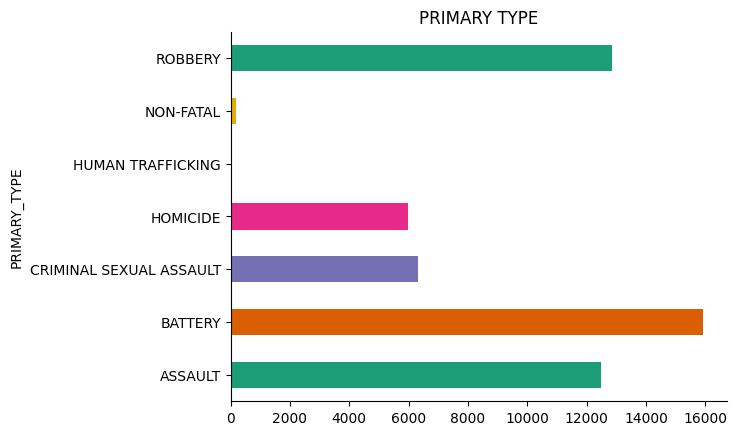

In [132]:
#Agrupa os dados pela coluna 'PRIMARY_TYPE' e constroi um gráfico de barra horizontal para identificar os crimes mais frequentes
dados.groupby('PRIMARY_TYPE').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('PRIMARY TYPE')

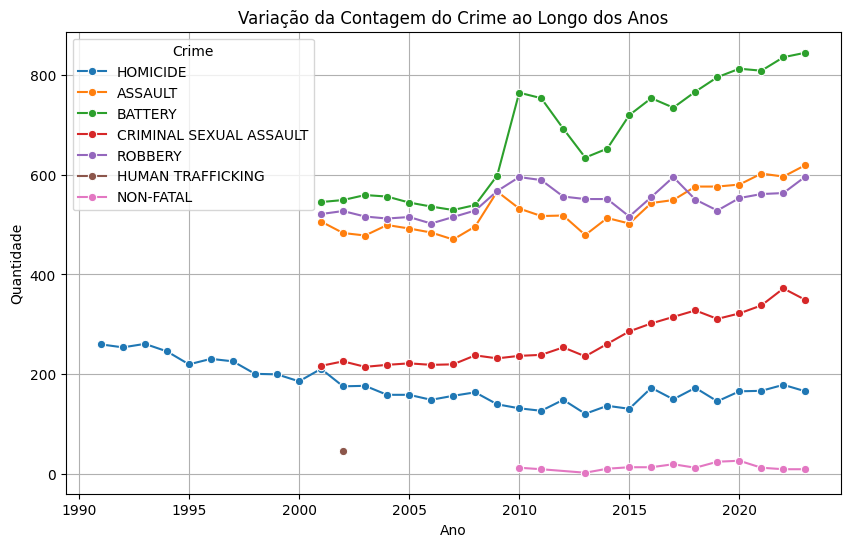

In [133]:
#Gráfico temporal da evolução do tipo de crime
#Identintificar o ano atual
ano_atual = datetime.now().year

#Pegar somente os dados dos anos anteriores ao ano atual
dados_exclude_year = dados[dados['yead'] < ano_atual]

#Contando a quantidade de vezes que cada característica aparece por ano
dados_counts = dados_exclude_year.groupby(['yead', 'PRIMARY_TYPE']).size().reset_index(name='count')

#Plotando o gráfico de linhas
plt.figure(figsize=(10, 6))

#Usando seaborn para plotar
sns.lineplot(data=dados_counts, x='yead', y='count', hue='PRIMARY_TYPE', marker='o')

#Adicionando títulos e rótulos
plt.title('Variação da Contagem do Crime ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.legend(title='Crime')
plt.grid(True)

#Exibindo o gráfico
plt.show()

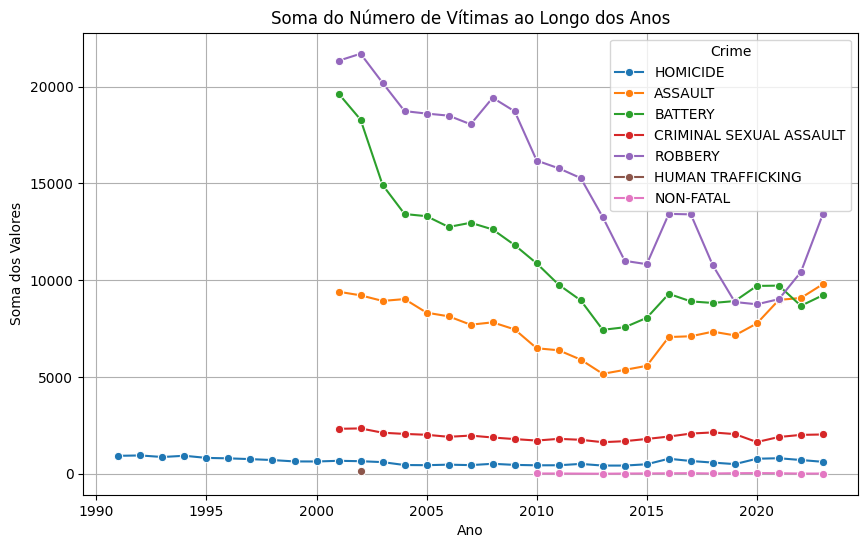

In [134]:
# Gráfico temporal da evolução da contagem de número de vítimas por tipo de crime
# Agrupando os dados por ano e característica, somando os valores
dados_soma_vitimas = dados_exclude_year.groupby(['yead', 'PRIMARY_TYPE'])['NUMBER_OF_VICTIMS'].sum().reset_index()

# Plotando o gráfico de linhas
plt.figure(figsize=(10, 6))

# Usando seaborn para plotar
sns.lineplot(data=dados_soma_vitimas, x='yead', y='NUMBER_OF_VICTIMS', hue='PRIMARY_TYPE', marker='o')

# Adicionando títulos e rótulos
plt.title('Soma do Número de Vítimas ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Soma dos Valores')
plt.legend(title='Crime')
plt.grid(True)

# Exibindo o gráfico
plt.show()

Text(0.5, 1.0, 'AGE')

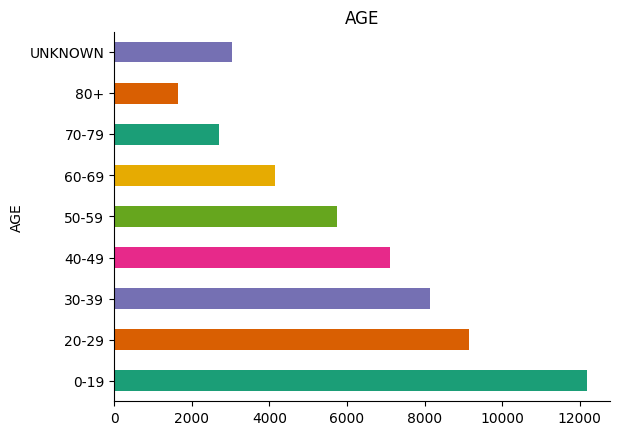

In [135]:
#Gráfico da faixa etária
#Agrupa os dados pela coluna 'AGE' e constroi um gráfico de barra horizontal para identificar a faixa etária mais acometida
dados.groupby('AGE').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('AGE')

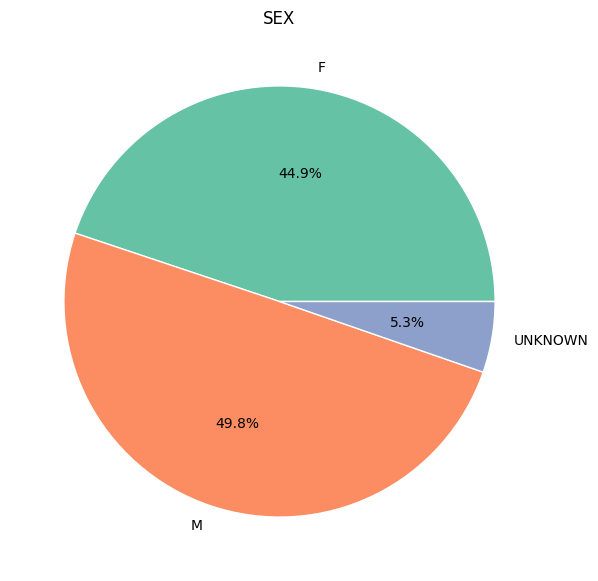

In [136]:
#Gráfico de sexo
#Agrupa os dados pela coluna 'SEX' e constroi um gráfico para identificar o sexo mais acometido
dados_agrupados = dados.groupby('SEX').size()
cores = sns.color_palette('Set2', len(dados_agrupados))

plt.figure(figsize=(10, 7))
plt.pie(dados_agrupados, labels=dados_agrupados.index, autopct='%1.1f%%', colors=cores, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('SEX')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'RACE')

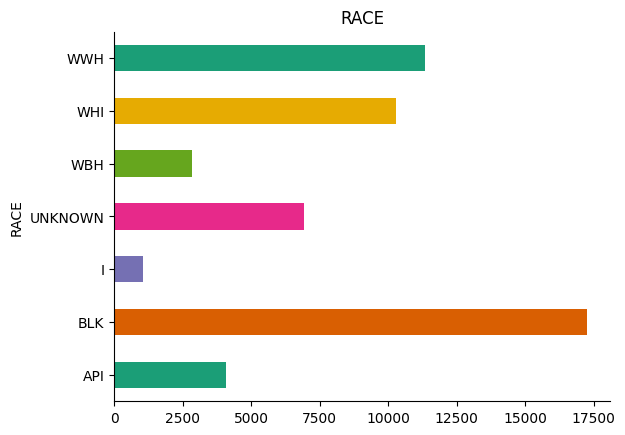

In [137]:
#Gráfico da raça
#Agrupa os dados pela coluba 'RACE' e constroi um gráfico de barra horizontal para identificar a raça mais acometida
dados.groupby('RACE').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('RACE')

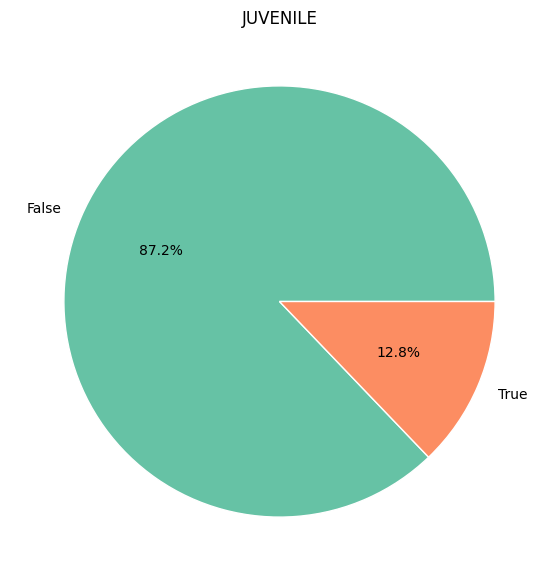

In [138]:
#Gráfico se as vítimas eram jovens
#Agrupa os dados pela coluna 'JUVENILE_I' e constroi um gráfico tipo pizza para identificar se as vítimas eram jovens
dados_agrupados = dados.groupby('JUVENILE_I').size()
cores = sns.color_palette('Set2', len(dados_agrupados))

plt.figure(figsize=(10, 7))
plt.pie(dados_agrupados, labels=dados_agrupados.index, autopct='%1.1f%%', colors=cores, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('JUVENILE')
plt.axis('off')
plt.show()

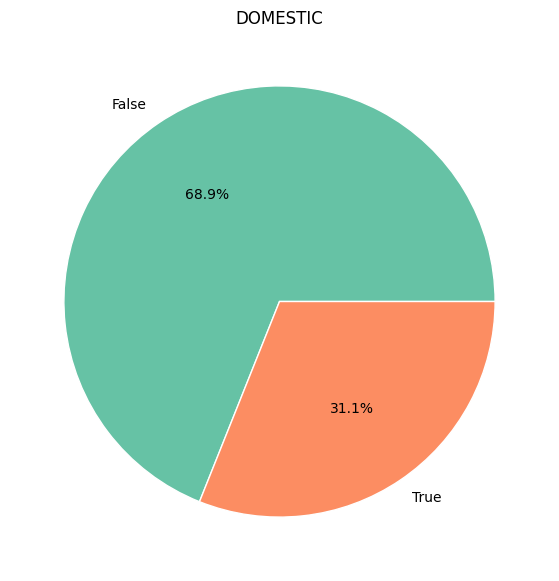

In [139]:
#Gráfico se foi um crime domestico
#Agrupa os dados pela coluna 'DOMESTIC_I' e constroi um gráfico tipo pizza para identificar se as vítimas era do ambito domestico
dados_agrupados = dados.groupby('DOMESTIC_I').size()
cores = sns.color_palette('Set2', len(dados_agrupados))

plt.figure(figsize=(10, 7))
plt.pie(dados_agrupados, labels=dados_agrupados.index, autopct='%1.1f%%', colors=cores, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('DOMESTIC')
plt.axis('off')
plt.show()

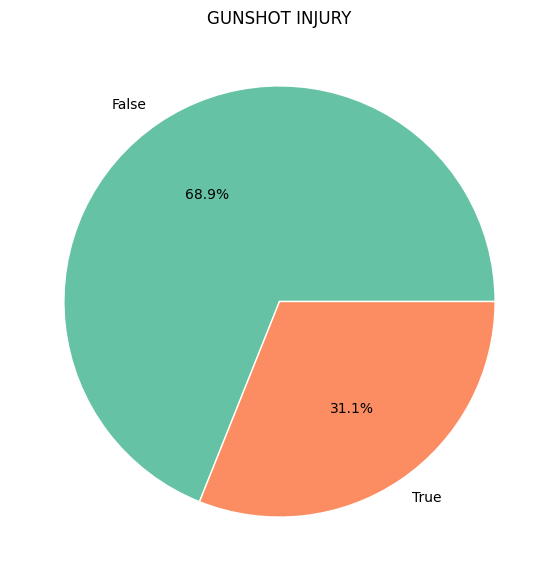

In [140]:
#Gráfico se foi um crime com uso de arma de fogo
#Agrupa os dados pela coluna 'GUNSHOT_INJURY_I' e constroi um gráfico tipo pizza para identificar se no crime teve uso de arma de fogo
ados_agrupados = dados.groupby('GUNSHOT_INJURY_I').size()
cores = sns.color_palette('Set2', len(dados_agrupados))

plt.figure(figsize=(10, 7))
plt.pie(dados_agrupados, labels=dados_agrupados.index, autopct='%1.1f%%', colors=cores, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('GUNSHOT INJURY')
plt.axis('off')
plt.show()

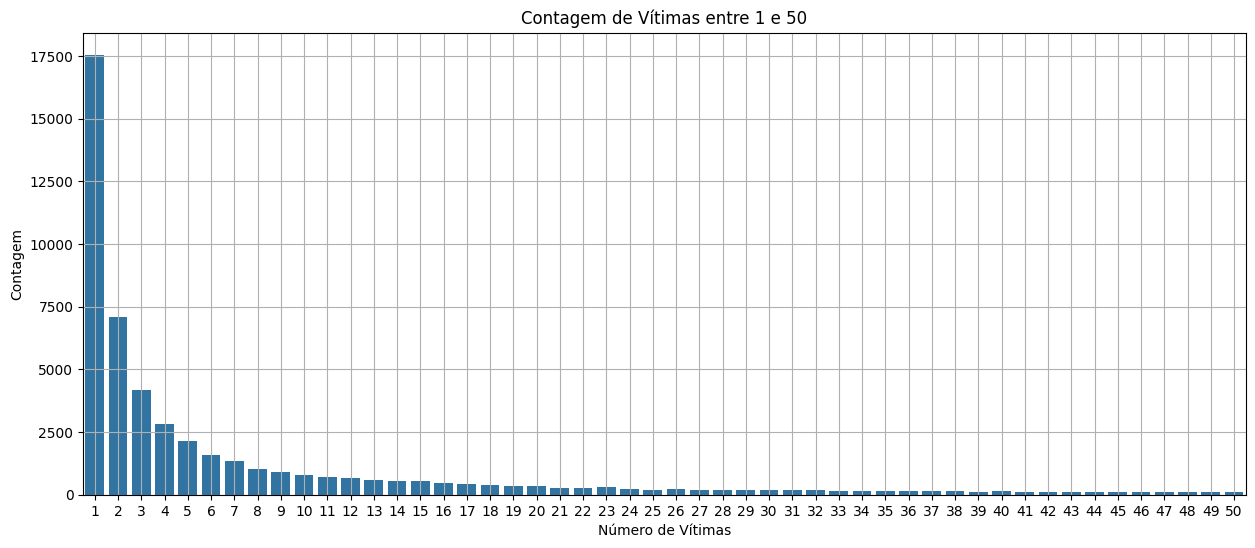

<ipython-input-141-5b5a94b70cce>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_valores_acima_50['intervalo'] = pd.cut(dados_valores_acima_50['NUMBER_OF_VICTIMS'], bins=bins, labels=labels, right=False)


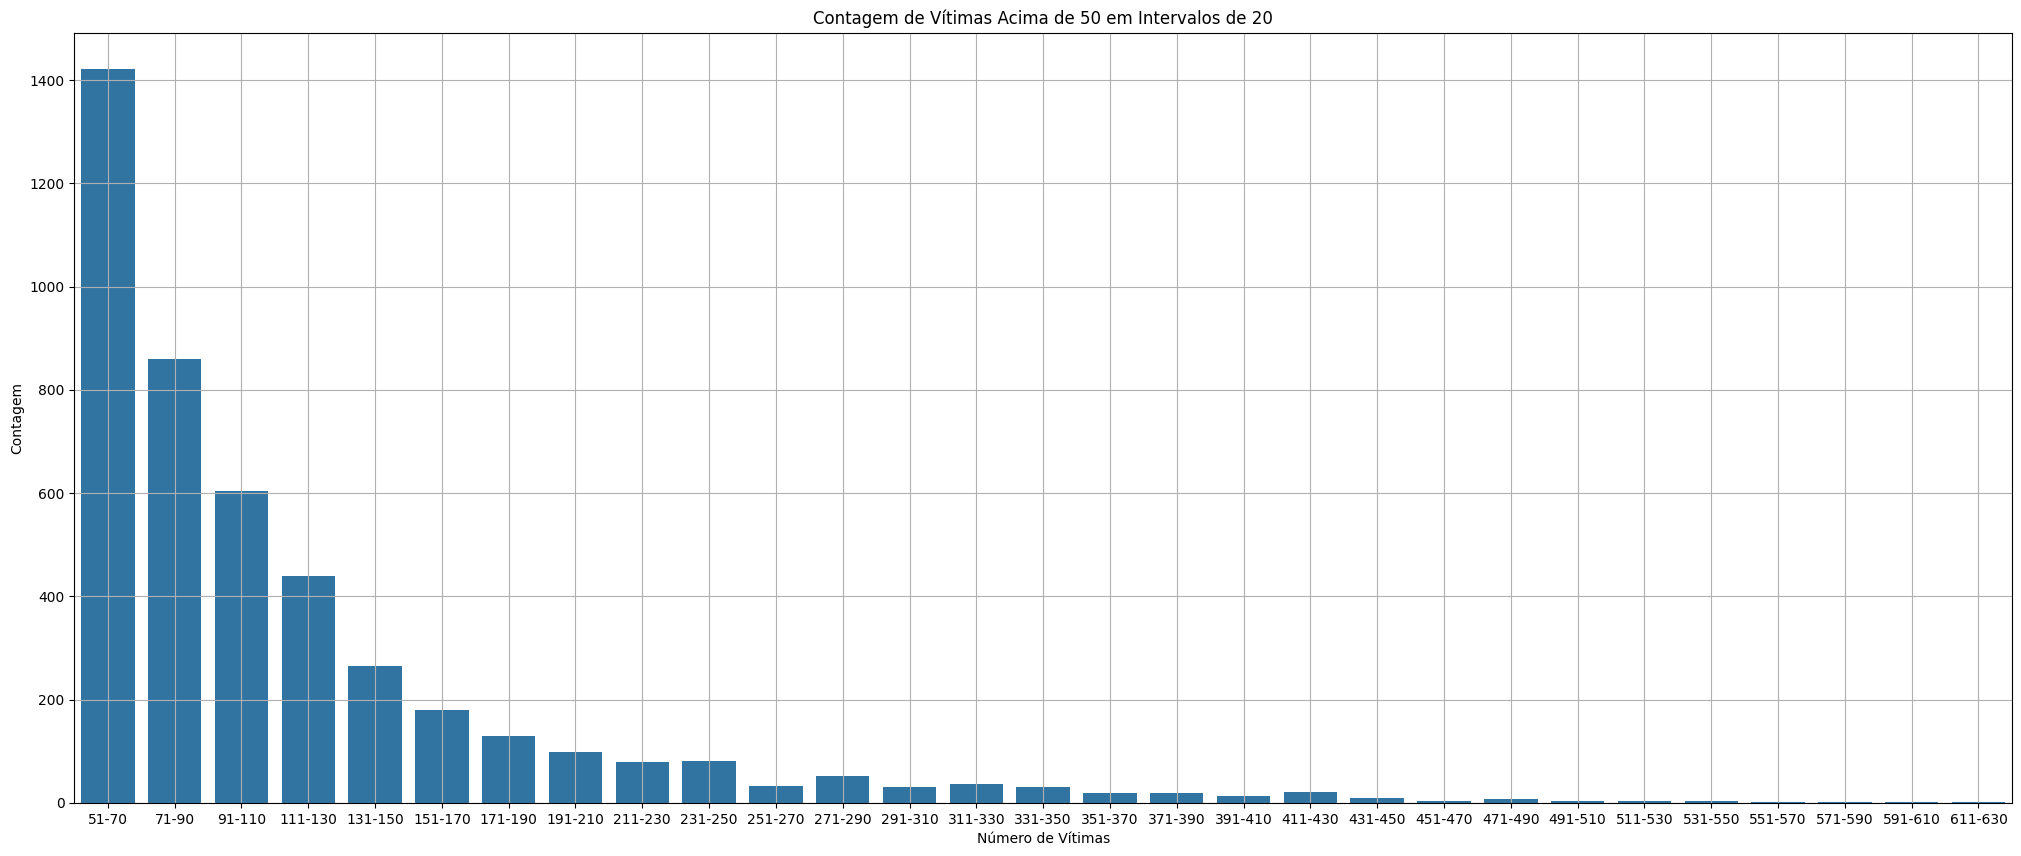

In [141]:
#Gradico de número de vítimas
#Plotando o primeiro gráfico: contagem de vitimas entre 1 e 50
dados.groupby('NUMBER_OF_VICTIMS')
dados_valores_1_50 = dados[dados['NUMBER_OF_VICTIMS'].between(1, 50)]
contagem_valores_1_50 = dados_valores_1_50['NUMBER_OF_VICTIMS'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
sns.barplot(x=contagem_valores_1_50.index, y=contagem_valores_1_50.values)
plt.title('Contagem de Vítimas entre 1 e 50')
plt.xlabel('Número de Vítimas')
plt.ylabel('Contagem')
plt.grid(True)
plt.show()

# Preparar o dataframe para vitimas acima de 50
dados_valores_acima_50 = dados[dados['NUMBER_OF_VICTIMS'] > 50]

# Criando intervalos de 20 em 20 para valores acima de 50
bins = list(range(51, dados['NUMBER_OF_VICTIMS'].max() + 20, 20))
labels = [f'{i}-{i + 19}' for i in bins[:-1]]
dados_valores_acima_50['intervalo'] = pd.cut(dados_valores_acima_50['NUMBER_OF_VICTIMS'], bins=bins, labels=labels, right=False)

# Contagem dos intervalos
contagem_valores_acima_50 = dados_valores_acima_50['intervalo'].value_counts().sort_index()

# Plotando o segundo gráfico: contagem de vitimas no intervalos de 20 em 20 (acima de 50)
plt.figure(figsize=(25, 10))
sns.barplot(x=contagem_valores_acima_50.index, y=contagem_valores_acima_50.values)
plt.title('Contagem de Vítimas Acima de 50 em Intervalos de 20')
plt.xlabel('Número de Vítimas')
plt.ylabel('Contagem')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: Valu

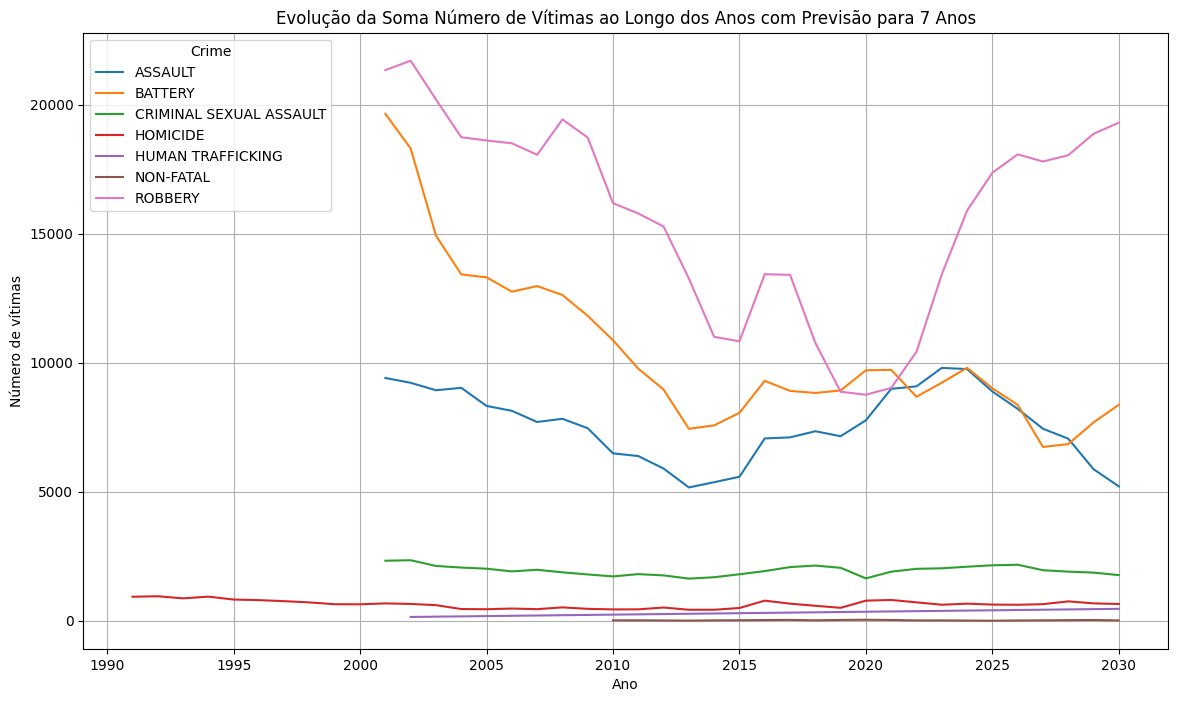

In [142]:
dados_pivot = dados_soma_vitimas.pivot(index='yead', columns='PRIMARY_TYPE', values='NUMBER_OF_VICTIMS')

# Treinando um modelo ARIMA para cada característica e fazendo previsões
future_years = 7
predictions = pd.DataFrame()

for characteristic in dados_pivot.columns:
    # Ajustando o modelo SARIMAX
    model = SARIMAX(dados_pivot[characteristic], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)

    # Fazendo previsões
    forecast = model_fit.forecast(steps=future_years)
    forecast.index = range(dados_pivot.index[-1] + 1, dados_pivot.index[-1] + 1 + future_years)
    predictions[characteristic] = forecast

# Combinando dados históricos e previsões
df_combined = pd.concat([dados_pivot, predictions])

# Plotando o gráfico
plt.figure(figsize=(14, 8))

for characteristic in df_combined.columns:
    sns.lineplot(data=df_combined[characteristic], label=characteristic)

# Adicionando títulos e rótulos
plt.title('Evolução da Soma Número de Vítimas ao Longo dos Anos com Previsão para 7 Anos')
plt.xlabel('Ano')
plt.ylabel('Número de vítimas')
plt.legend(title='Crime')
plt.grid(True)

# Exibindo o gráfico
plt.show()

In [143]:
# Normalizar os dados
scaler = MinMaxScaler()
dados_scaled = scaler.fit_transform(dados_pivot)

# Função para criar a sequência de dados para RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Definindo o tamanho da sequência
seq_length = 7

# Criar sequências
X, y = create_sequences(dados_scaled, seq_length)

# Dividir os dados em conjuntos de treino e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [144]:
# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, dados_pivot.shape[1])))
model.add(Dense(dados_pivot.shape[1]))
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/200
2/2 [==============================] - 2s 301ms/step - loss: nan - val_loss: nan
Epoch 2/200
2/2 [==============================] - 0s 36ms/step - loss: nan - val_loss: nan
Epoch 3/200
2/2 [==============================] - 0s 34ms/step - loss: nan - val_loss: nan
Epoch 4/200
2/2 [==============================] - 0s 37ms/step - loss: nan - val_loss: nan
Epoch 5/200
2/2 [==============================] - 0s 36ms/step - loss: nan - val_loss: nan
Epoch 6/200
2/2 [==============================] - 0s 56ms/step - loss: nan - val_loss: nan
Epoch 7/200
2/2 [==============================] - 0s 41ms/step - loss: nan - val_loss: nan
Epoch 8/200
2/2 [==============================] - 0s 35ms/step - loss: nan - val_loss: nan
Epoch 9/200
2/2 [==============================] - 0s 36ms/step - loss: nan - val_loss: nan
Epoch 10/200
2/2 [==============================] - 0s 34ms/step - loss: nan - val_loss: nan
Epoch 11/200
2/2 [==============================] - 0s 37ms/step - loss: nan -

In [145]:
# Fazer previsões no conjunto de teste
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)

# Fazer previsões futuras
future_steps = 7
last_sequence = dados_scaled[-seq_length:]
future_predictions = []

for _ in range(future_steps):
    next_pred = model.predict(last_sequence.reshape(1, seq_length, dados_pivot.shape[1]))
    future_predictions.append(next_pred[0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

future_predictions_rescaled = scaler.inverse_transform(future_predictions)

1/1 [==============================] - 0s 21ms/step


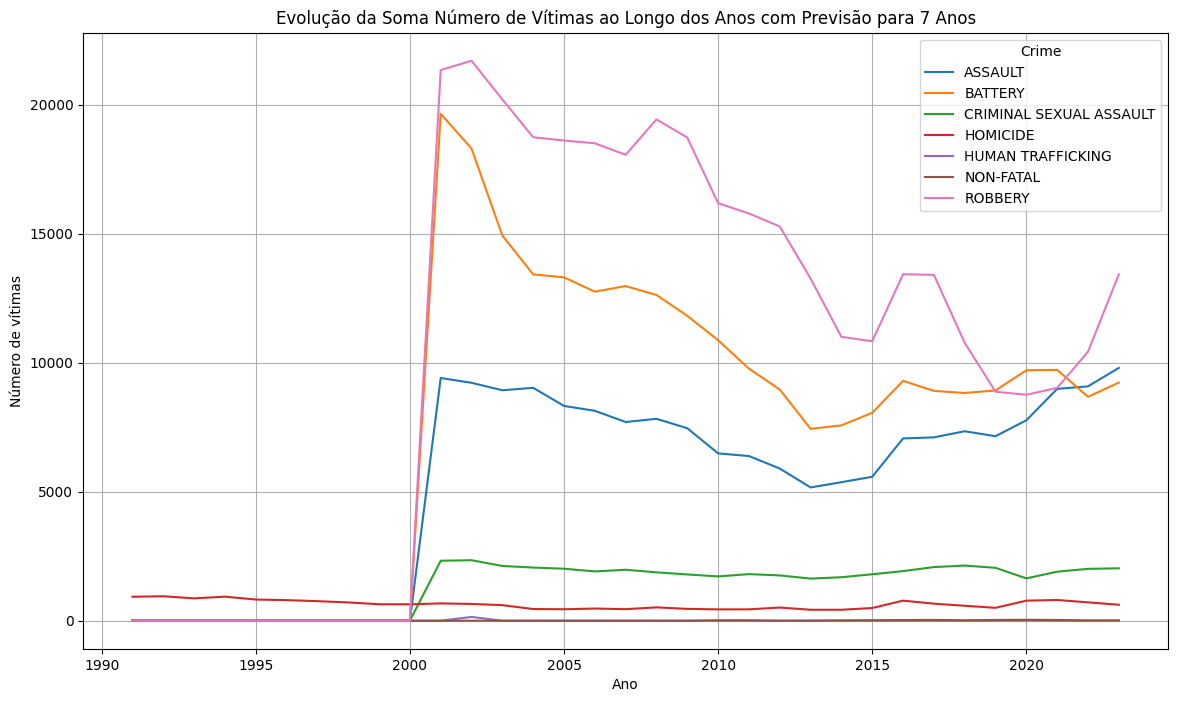

In [161]:
# Combinar dados históricos e previsões
future_years = range(dados_pivot.index[-1] + 1, dados_pivot.index[-1] + 1 + future_steps)
predictions_df = pd.DataFrame(future_predictions_rescaled, index=future_years, columns=dados_pivot.columns)
df_combined = pd.concat([dados_pivot, predictions_df])

# Plotar o gráfico
plt.figure(figsize=(14, 8))

for characteristic in df_combined.columns:
    sns.lineplot(data=df_combined[characteristic], label=characteristic)

# Adicionando títulos e rótulos
plt.title('Evolução da Soma Número de Vítimas ao Longo dos Anos com Previsão para 7 Anos')
plt.xlabel('Ano')
plt.ylabel('Número de vítimas')
plt.legend(title='Crime')
plt.grid(True)

# Exibindo o gráfico
plt.show()